In [1]:
import numpy as np
import pandas as pd

booking = pd.read_csv("../data/booking.csv")
booking.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,Agent,Company,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000,118565.000000
mean,0.372589,104.505832,2016.157635,27.157028,15.799595,0.932096,2.512790,1.860009,0.104196,0.007962,0.082056,0.087631,0.137182,0.218361,74.784692,10.680353,2.333016,102.523863,0.062759,0.571931
std,0.483496,106.915519,0.707714,13.589350,8.782227,0.995462,1.893258,0.575441,0.399119,0.097560,0.274452,0.847172,1.500699,0.637629,107.112200,53.719120,17.642783,50.005428,0.245743,0.793281
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,70.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


## Feature Engineering

Ta sẽ xử lý các cột không phải là số.

1. Loại bỏ giá trị lớn nhất của cột **LeadTime** vì là outlier

In [2]:
booking = booking[booking.LeadTime < 700]
booking = booking.reset_index(drop=True)

2. Cột **Country** có quá nhiều unique value, ta sẽ map cột country với xác suất người thuộc đất nước đó huỷ booking, đồng thời bỏ các dòng giá trị nan

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapCountryColumn(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.country_map = {}
        
    def fit(self, X, y):
        vc_all = X.loc[:, 39].value_counts()
        vc_pos = X[y==1].loc[:, 39].value_counts()

        for key in vc_all.keys():
            count_pos = vc_pos.get(key, default=0)
            self.country_map[key] = count_pos / vc_all.get(key)
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        for code in copy.loc[:, 39]:
            if code not in self.country_map:
                self.country_map[code] = 0
        copy.loc[:, 39] = copy.loc[:, 39].map(self.country_map)
        return copy

3. **ReservationStatus** và **ReservationStatusDate** chứa thông tin sau khi khách trả phòng, ta bỏ 2 cột này. Bỏ cột **ArrivalDateYear**, các cột **ArrivalDateMonth**, **ArrivalDateWeekNumber**, **ArrivalDateDayOfMonth** cũng có thể bỏ nếu  chỉ tăng hiệu năng model lên không đáng kể.

In [4]:
cols = ['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', \
        'ArrivalDateWeekNumber', 'ReservationStatus', 'ReservationStatusDate']

booking = booking.drop(cols, axis=1)

4. Đổi giá trị trong một số cột từ số thành boolean ("có" hay "không")

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToBooleanColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, df, y=None):
        return df.apply(lambda x : x.apply(lambda x : min(1, x)))

5. Tạo cột **IsDesiredRoomType**

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class CreateIsDesiredRoomTypeColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, booking, y=None):
        booking['IsDesiredRoomType'] = booking.ReservedRoomType == booking.AssignedRoomType
        booking.IsDesiredRoomType = booking.IsDesiredRoomType.astype(int)
        return booking.drop(['ReservedRoomType', 'AssignedRoomType'], axis=1)

6. One-hot encode các categorical features

In [7]:
booking['NumsOfStays'] = booking.loc[:,['StaysInWeekendNights','StaysInWeekNights']].sum(axis=1)
booking['NumsOfPeople'] = booking.loc[:,['Adults','Children','Babies']].sum(axis=1)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['MarketSegment', 'CustomerType', 'DistributionChannel', 'DepositType', \
        'Meal', 'HotelType']
num_cols = ['LeadTime', 'NumsOfStays', 'NumsOfPeople', 'Agent', 'ADR']
room_type_cols = ['ReservedRoomType', 'AssignedRoomType']
to_bool_cols = ['DaysInWaitingList', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', \
    'PreviousCancellations', 'PreviousBookingsNotCanceled', 'Company', 'BookingChanges']
preserved_cols = ['Country']

class PreserveColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, booking, y=None):
        return booking


num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
     ("num", num_pipeline, num_cols),
     ("cat", OneHotEncoder(), cat_cols),
     ("roomtype", CreateIsDesiredRoomTypeColumn(), room_type_cols),
     ("bool", ToBooleanColumn(), to_bool_cols),
     ("preserve", PreserveColumn(), preserved_cols),
 ])
booking_prepared = full_pipeline.fit_transform(booking)

In [10]:
booking_prepared

array([[-0.9120647916993501, -0.964767588287128, -1.3519423003547675,
        ..., 0, 0, 'GBR'],
       [-0.8559381500015265, -0.964767588287128, -1.3519423003547675,
        ..., 0, 0, 'GBR'],
       [-0.8465837097185559, -0.5701279136347203, 0.038706010473094285,
        ..., 0, 0, 'GBR'],
       ...,
       [-0.6594949040591442, 1.4030704596273187, 0.038706010473094285,
        ..., 0, 0, 'DEU'],
       [0.042088117163649526, 1.4030704596273187, 0.038706010473094285,
        ..., 0, 0, 'GBR'],
       [0.9401143843288255, 2.1923498089321343, 0.038706010473094285,
        ..., 0, 0, 'DEU']], dtype=object)

## Modeling

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

X = pd.DataFrame(booking_prepared)
y = booking.IsCanceled

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=41)
for train_index, test_index in split.split(X, y):
    X_t = X.loc[train_index]
    y_t = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
X_t = X_t.reset_index(drop=True)
y_t = y_t.reset_index(drop=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24)
for train_index, test_index in split.split(X_t, y_t):
    X_train = X_t.loc[train_index]
    y_train = y_t.loc[train_index]
    X_valid = X_t.loc[test_index]
    y_valid = y_t.loc[test_index]

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def print_scores(model, X_valid, y_valid):
    pred = model.predict(X_valid)
    print('Accuracy: ', accuracy_score(y_valid, pred))
    print('Precision: ', precision_score(y_valid, pred))          
    print('Recall: ', recall_score(y_valid, pred))

### MLP

In [13]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neural_network import MLPClassifier

class MyMLP(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_sizes=(100), random_state=1, max_iter=300):
        self.mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=max_iter)
        self.country_mapper = MapCountryColumn()
    def fit(self, X, y):
        self.mlp.fit(self.country_mapper.fit_transform(X, y), y)
        return self

    def predict(self, X):
        return self.mlp.predict(self.country_mapper.transform(X))
    
    def predict_proba(self, X):
        return self.mlp.predict_proba(self.country_mapper.transform(X))

In [14]:
mlp = MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500).fit(X_train, y_train.values.ravel())

### Ranfom Forest Classifier

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestClassifier

class MyRandomForest(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100):
        self.rf = RandomForestClassifier(n_estimators=n_estimators)
        self.country_mapper = MapCountryColumn()
        
    def fit(self, X, y):
        self.rf.fit(self.country_mapper.fit_transform(X, y), y)
        return self

    def predict(self, X):
        return self.rf.predict(self.country_mapper.transform(X))
    
    def predict_proba(self, X):
        return self.rf.predict_proba(self.country_mapper.transform(X))

In [16]:
rf = MyRandomForest().fit(X_train, y_train.values.ravel())

# Evaluation

In [17]:
def evaluate_model(model, times=5):
    accuracy = []
    precision = []
    recall = []

    for i in range(times):
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24+i)
        for train_index, test_index in split.split(X_t, y_t):
            X_train = X_t.loc[train_index]
            y_train = y_t.loc[train_index]
            X_valid = X_t.loc[test_index]
            y_valid = y_t.loc[test_index]
        print("fitting ", i+1)
        model.fit(X_train, y_train.values.ravel())
        accuracy.append(accuracy_score(y_valid, model.predict(X_valid)))
        precision.append(precision_score(y_valid, model.predict(X_valid)))    
        recall.append(recall_score(y_valid, model.predict(X_valid)))    

    print('Accuracy: ', ["%0.2f" % i for i in accuracy], '. Avg: ', sum(accuracy)/times)
    print('Precision: ', ["%0.2f" % i for i in precision], '. Avg: ', sum(precision)/times)        
    print('Recall: ', ["%0.2f" % i for i in recall], '. Avg: ', sum(recall)/times) 

In [ ]:
evaluate_model(MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500))

In [18]:
evaluate_model(MyMLP(hidden_layer_sizes=(20,20), random_state=2, max_iter=500))

fitting  1
fitting  2
fitting  3
fitting  4
fitting  5
Accuracy:  ['0.86', '0.86', '0.86', '0.86', '0.85'] . Avg:  0.8569817089241475
Precision:  ['0.85', '0.84', '0.82', '0.84', '0.81'] . Avg:  0.834177634962549
Recall:  ['0.76', '0.76', '0.78', '0.76', '0.79'] . Avg:  0.7696378041878891


In [19]:
accuracy_score(y_train, mlp.predict(X_train))

0.8616895097522403

In [20]:
print_scores(mlp, X_valid, y_valid)

Accuracy:  0.8596278530388488
Precision:  0.8387940316874327
Recall:  0.771505376344086


In [21]:
evaluate_model(MyRandomForest(n_estimators=50))

fitting  1
fitting  2
fitting  3
fitting  4
fitting  5
Accuracy:  ['0.88', '0.88', '0.88', '0.88', '0.88'] . Avg:  0.8821148068103948
Precision:  ['0.86', '0.86', '0.86', '0.87', '0.86'] . Avg:  0.8621721139518342
Recall:  ['0.81', '0.81', '0.81', '0.81', '0.81'] . Avg:  0.8136672325976232


In [ ]:
print_scores(rf, X_valid, y_valid)

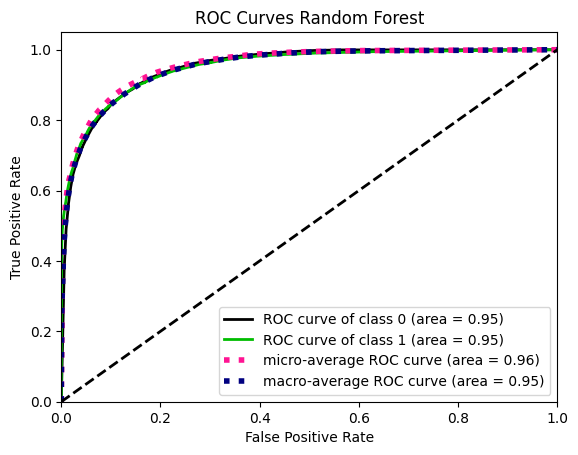

In [22]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

rf = MyRandomForest(n_estimators=50).fit(X_train, y_train.values.ravel())

y_true = y_valid
y_probas = rf.predict_proba(X_valid)
plot_roc(y_true, y_probas, title='ROC Curves Random Forest')
plt.show()

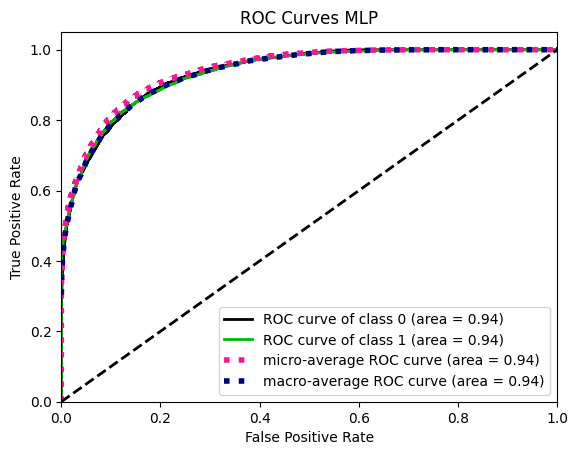

In [23]:
mlp = MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500).fit(X_train, y_train.values.ravel())

y_true = y_valid
y_probas = mlp.predict_proba(X_valid)
plot_roc(y_true, y_probas, title='ROC Curves MLP')
plt.show()

In [24]:
print("MLP: ", accuracy_score(y_test, mlp.predict(X_test)))
print("Random Forest: ", accuracy_score(y_test, rf.predict(X_test)))

MLP:  0.855986167924767
Random Forest:  0.8830599249356893
